In [1]:
#path = 'saved_model_1113_(480, 576)_RGB_False_ACC_0.989_3rd_data_all'
#path = 'saved_model_1112_(480, 576)_RGB_False_ACC_0.988_3rd_data_TFTT'
#path = 'saved_model_1112_(480, 576)_RGB_False_ACC_0.987_3rd_data_FFTF'
#path = 'saved_model_1115_(480, 576)_RGB_False_ACC_0.987_3rd_data_all'
#path = 'saved_model_1115_(960, 1152)_RGB_False_ACC_0.988_3rd_data_FFFT'
#path = 'saved_model_1112_(480, 576)_RGB_False_ACC_0.986_3rd_data_TFFF' #Bright,Flip,Rotate,Shift
#path = 'saved_model_1112_(480, 576)_RGB_False_ACC_0.987_3rd_data_FFTF'
#path = 'saved_model_1113_(480, 576)_RGB_False_ACC_0.987_3rd_data_FFFT'
#path = 'saved_model_1115_(960, 1152)_RGB_False_ACC_0.99_3rd_data_FFTF'
#path = 'saved_model_1118_(480, 576)_RGB_False_ACC_0.988_3rd_data_FFTTT'

#path = 'saved_model_1123_(480, 576)_RGB_False_ACC_0.958_1tab_FFTFF'
#path = 'saved_model_1124_(480, 576)_RGB_False_ACC_0.987_1tab_FFTFF'

#path = 'saved_model_1125_(480, 576)_RGB_False_ACC_0.987_1tab_val_FFTFF'
#path = 'saved_model_1201_(480, 576)_ACC_0.99_1tab_train_Focal_all'
#path = 'saved_model_UNET_1201_ACC_0.99_1tab_val_combined_loss_all'

path = 'saved_model_Unet_1202_ACC_0.99_alltrain_combined_loss_FFTFF'

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np
from numpy import genfromtxt
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

import glob
import cv2
import gc

from tqdm import tqdm
import time

2.2.0


In [3]:
IMG_SIZE_L = [(480,576), (960,1152)] #(480,576) #1200, 1392  960, 1152
IMG_SIZE = IMG_SIZE_L[0]

In [4]:
def display(display_list, idx=None, loc='.', name='label', only_inference=False, 
            fig_size=15, title=['Ground Truth Mask', 'Pushed', 'Stamped'],gray=True):
    """
    "only_inference" = True creates sample of inferenced image PNG file.
    """
    if only_inference:
        for lab,i in enumerate(range(len(display_list))):
            plt.figure(figsize=(fig_size,fig_size))
            a = np.array(display_list[i])
            a = a.astype(np.float32) * 255.0

            plt.imshow(tf.keras.preprocessing.image.array_to_img(a))
            #cv2.imwrite(loc+"/Image{}".format(idx)+"_{}{}.png".format(name,lab+1), cv2.cvtColor(a, cv2.COLOR_RGB2BGR))
    
    else:
        plt.figure(figsize=(fig_size,fig_size))
        #title = ['Ground Truth Mask', 'Pushed', 'Stamped', 'hole']

        for i in range(len(display_list)):
            if i == 0 and gray:
                COLOR = 'gray'
            else:
                COLOR = None
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap = COLOR)
            plt.axis('off')

        plt.show()
    

In [5]:
def create_mask(pred_mask, num=0):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
    if test_mode:
        print("In testing Mode...")
        if y is not None:
            for i in range(num):
                pred_mask = model.predict(x, batch_size=1)
                display([x[i], y[i], create_mask(pred_mask, num=i)])
        else:
            for i in range(num):
                pred_mask = model.predict(x, batch_size=1)
                display([x[i], create_mask(pred_mask, num=i)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [6]:
def draw_and_count(img, contours, label = '', draw_type = 'contour', show=True):
    # img : original image
    # contours: Contours found from opencv code
    assert label in ['push', 'stamp', 'hole'], "label must be either 'push' or 'stamp'"
    assert draw_type in ['bbox', 'contour'], "draw type must be either 'bbox' or 'contour'"
    
    if label=='push': val = 220
    if label=='stamp': val = 150
    if label=='hole': val = 250
        
        
    count = 0
    area = []
    width_height = []
    
    for idx, cnt in enumerate(contours):
        a = cv2.contourArea(cnt)
        if a < val:
            continue
        
        area.append(a)
        count += 1
        
        if draw_type == 'bbox':
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(125,125,0),2)
            width_height.append([w,h])
            print("{} #{} has width of {} and height of {}".format(label, idx, w, h))
            
        elif draw_type == 'contour':
            cv2.drawContours(img, [cnt], 0, (125, 125, 0), 2) 
            
    if show:        
        display([img], fig_size=8)
        print("{} {} found. Area: {}".format(count,label,area))

        
    return img, area, width_height, count

{0: [0.0, 0.0, 0.0], 1: [0.0, 1.0, 0.0], 2: [0.0, 1.0, 1.0], 3: [1, 1, 0], 4: [1.0, 0.23529411764705882, 0.23529411764705882], 5: [1.0, 0.5490196078431373, 0.0], 6: [0.23137254901960785, 0.23137254901960785, 1.0]}


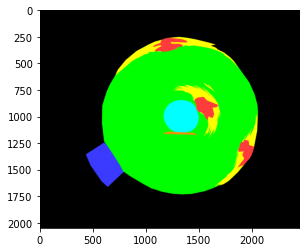

In [7]:
import cv2
from itertools import product

loc = "../../data/LGES_Vision/JR_Bottom/0.Data/211110_3rd_data/"

mask = cv2.imread(loc + 'Mask_Image/[2021-10-13]11.25.55.086_1_2_Image.png') #2048 x 2448
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) / 255.0

cc = cv2.inRange(mask, (.99, 0, .99), (1,0,1))
mask[cc != 0] = [0,1,0]

colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

plt.imshow(mask)

color_dict = {i: list(x) for i,x in enumerate(colors)}

color_dict[6] = color_dict[3]
color_dict[3] = [1,1,0]

print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

# WITHOUT TRT

In [21]:
model = tf.keras.models.load_model(path,compile=False)

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 480, 576, 1)]     0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 480, 576, 3)       6         
_________________________________________________________________
model (Model)                (None, 480, 576, 7)       29933975  
Total params: 29,933,981
Trainable params: 29,897,565
Non-trainable params: 36,416
_________________________________________________________________


In [10]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

model = tf.saved_model.load(path, tags=[trt.tag_constants.SERVING])
graph_func = model.signatures[trt.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
frozen_func = trt.convert_to_constants.convert_variables_to_constants_v2(graph_func)

In [31]:
time_list = []
pred_mask = []
val_x = []
val_y = []

loc_1tab = "JR_1Tab_20211119_labeling/*/*.bmp"
files = glob.glob(loc_1tab)

""" 1Tab DATA """ #47 IMAGES USED FOR TRAINING
"""
for idx, img in enumerate(files):
    n = cv2.imread(img, 0)
    n = tf.expand_dims(n,-1)

    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) 

    val_x.append(n)

    # MASK
    file_name = img.split("/")
    png_name = "JR_1tab_mask/" + file_name[-1][:-4] + '.png'

    y = cv2.imread(png_name)
    y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB) / 255.0
    cc = cv2.inRange(y, (.99, 0, .99), (1,0,1))
    y[cc != 0] = [0,1,0]
    a = rgb_to_onehot(y, color_dict) #change to one hot
    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot -> 0,1,2,3,4,5,6
    mask = tf.image.resize(bb, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = np.round(mask)

    val_y.append(mask)

    start = time.time()

    image = tf.expand_dims(n,0)
    pred_mask.append(frozen_func(image)) # idx, 1, 1, H, W, 4
"""


with open("Val_img.txt") as f:
    for idx,line in enumerate(f):
        img = line.splitlines()[0]
        
        n = cv2.imread(loc + "Original_Image/" + img, 0 ) # Gray Scale
        n = tf.expand_dims(n,-1)
        
        #n = cv2.imread("JR_lower_part/Original_Image/" + img)
        #n = cv2.cvtColor(cv2.imread("JR_lower_part/Original_Image/" + img,), cv2.COLOR_BGR2RGB) # Gray RGB
        
        n = tf.cast(n, tf.float32) / 255.0
        n = tf.image.resize(n, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        val_x.append(n)
        #MASK
        y = cv2.imread(loc + "Mask_Image/" + img) # imread(dir+file_name+".png")
        y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB) / 255.0
        
        cc = cv2.inRange(y, (.99, 0, .99), (1,0,1))

        y[cc != 0] = [0,1,0]
        a = rgb_to_onehot(y, color_dict) #change to one hot

        bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
        mask = tf.image.resize(bb, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        val_y.append(mask)
        
        start = time.time()

        image = tf.expand_dims(n,0)
        pred_mask.append(frozen_func(image)) # idx, 1, 1, H, W, 4

        time_list.append(time.time()-start)
        if idx == 10: break
    
print("Average inference time is: ",(np.mean(time_list) * 1000).round(3), "ms")

val_x = tf.convert_to_tensor(val_x)
val_y = tf.convert_to_tensor(val_y)

Average inference time is:  17.17 ms


In [40]:
pred_mask = []
val_x = []

img_dir_l = ["dataset/2021-11-01-09/*.bmp", "dataset/Raw/*.bmp", "dataset/DL_Pressed/*.bmp", "dataset/211124_oc4_jr/All_NG/*.bmp"] 

img_dir = img_dir_l[3]

for img in glob.glob (img_dir):
    n = cv2.imread(img, 0) # Gray Scale
    n = tf.expand_dims(n,-1)
    #n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB) # Gray RGB
    #n = tf.expand_dims(n,-1) #Gray Scale

    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    val_x.append(n)
    #MASK

    image = tf.expand_dims(n,0)
    pred_mask.append(frozen_func(image)) # idx, 1, 1, H, W, 4

val_x = tf.convert_to_tensor(val_x)
print(val_x.shape)

(8, 480, 576, 1)


Ground truth numbers:
1.   black_ng:
1, 2/1, 3, 4, 4/2, 4/2, 3/1, 1, 1, 4/1
3/3, 2, 4/1, 3/1
2.   silver_ng:
4, 4/1, 4/2, 3/1, 1, 1/1, 4/1,
3/2, 2, 4, 2/1




In [13]:
"""
np.savez_compressed('test_img_array', test_0 = np.float32(pred_mask[0][0][0]), test_1 = np.float32(pred_mask[1][0][0]), 
                   test_2 = np.float32(pred_mask[2][0][0]), test_3 = np.float32(pred_mask[3][0][0]))
"""

"\nnp.savez_compressed('test_img_array', test_0 = np.float32(pred_mask[0][0][0]), test_1 = np.float32(pred_mask[1][0][0]), \n                   test_2 = np.float32(pred_mask[2][0][0]), test_3 = np.float32(pred_mask[3][0][0]))\n"

In [13]:
print(val_x.shape[0])

20


In [32]:
def onehot_to_rgb(one_hot, label = None):
    #0 bg 1 circle 2 hole 3push 4stamped

    channel_0 = np.zeros(IMG_SIZE + (1,)) #prediction
    channel_1 = np.zeros(IMG_SIZE + (1,))
    channel_2 = np.zeros(IMG_SIZE + (1,))
    
    ex = one_hot # ex = H,W,1
    
    if label:
        channel_0[ex==1] = color_dict[label][0]
        channel_1[ex==1] = color_dict[label][1]
        channel_2[ex==1] = color_dict[label][2]
        com = tf.concat([channel_0, channel_1, channel_2], -1)
        return com

    channel_0[ex==1] = color_dict[1][0]
    channel_1[ex==1] = color_dict[1][1]
    channel_2[ex==1] = color_dict[1][2]

    channel_0[ex==3] = color_dict[3][0]
    channel_1[ex==3] = color_dict[3][1]
    channel_2[ex==3] = color_dict[3][2]

    channel_0[ex==2] = color_dict[2][0]
    channel_1[ex==2] = color_dict[2][1]
    channel_2[ex==2] = color_dict[2][2]

    channel_0[ex==0] = color_dict[0][0]
    channel_1[ex==0] = color_dict[0][1]
    channel_2[ex==0] = color_dict[0][2]
    
    channel_0[ex==4] = color_dict[4][0]
    channel_1[ex==4] = color_dict[4][1]
    channel_2[ex==4] = color_dict[4][2]
    
    channel_0[ex==5] = color_dict[5][0]
    channel_1[ex==5] = color_dict[5][1]
    channel_2[ex==5] = color_dict[5][2]
    
    channel_0[ex==6] = color_dict[6][0]
    channel_1[ex==6] = color_dict[6][1]
    channel_2[ex==6] = color_dict[6][2]
    

    com = tf.concat([channel_0, channel_1, channel_2], -1)
    
    return com

In [76]:
av = []
num_pix = []


for idx in range(46,56):
    bgg = pred_mask[idx][0][0][:,:,0]

    av.append(np.mean(bgg[140:340,188:388] [bgg[140:340,188:388] > 0.5])) #480 576 # 140 ~ 340   188 ~ 388    288
    num_pix.append(len(bgg[140:340,188:388] [bgg[140:340,188:388] > 0.5]))

In [78]:
print(av)
print(np.mean(num_pix))

[0.963704, 0.97469705, 0.97320884, 0.9727261, 0.9570103, 0.97043574, 0.9727745, 0.97500026, 0.9685038, 0.96441066]
335.4


(array([0., 1.], dtype=float32), array([261002,  15478]))


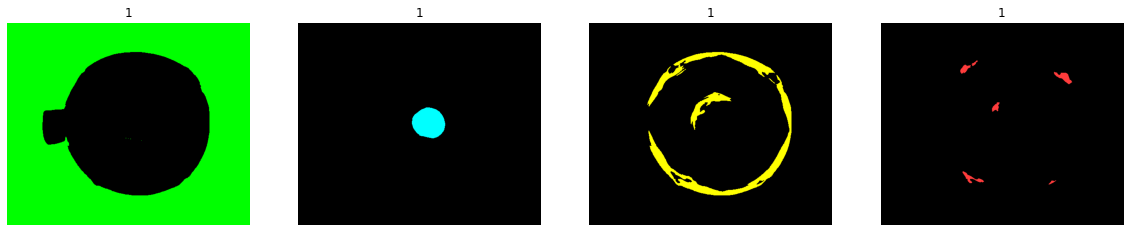

In [36]:
idx=4

pred = np.float32(pred_mask[idx][0][0])

ex = np.round(pred) # ex = H,W,7

circle = tf.expand_dims(ex[:,:,1], -1)
pushed = tf.expand_dims(ex[:,:,3], -1) 
bg = tf.expand_dims(ex[:,:,0], -1)
hole = tf.expand_dims(ex[:,:,2], -1)
stamped = tf.expand_dims(ex[:,:,4], -1)
in_tab = tf.expand_dims(ex[:,:,5], -1)
out_tab = tf.expand_dims(ex[:,:,6], -1)

print(np.unique(pushed,return_counts=True))

#bg = 0, pushed = 1, stamped = 2, circle = 3

display([onehot_to_rgb(bg,label=0), onehot_to_rgb(hole,label=2), 
         onehot_to_rgb(pushed,label=3), onehot_to_rgb(stamped, label=4)], title=['1','1','1','1'],
        fig_size=20, gray= False)

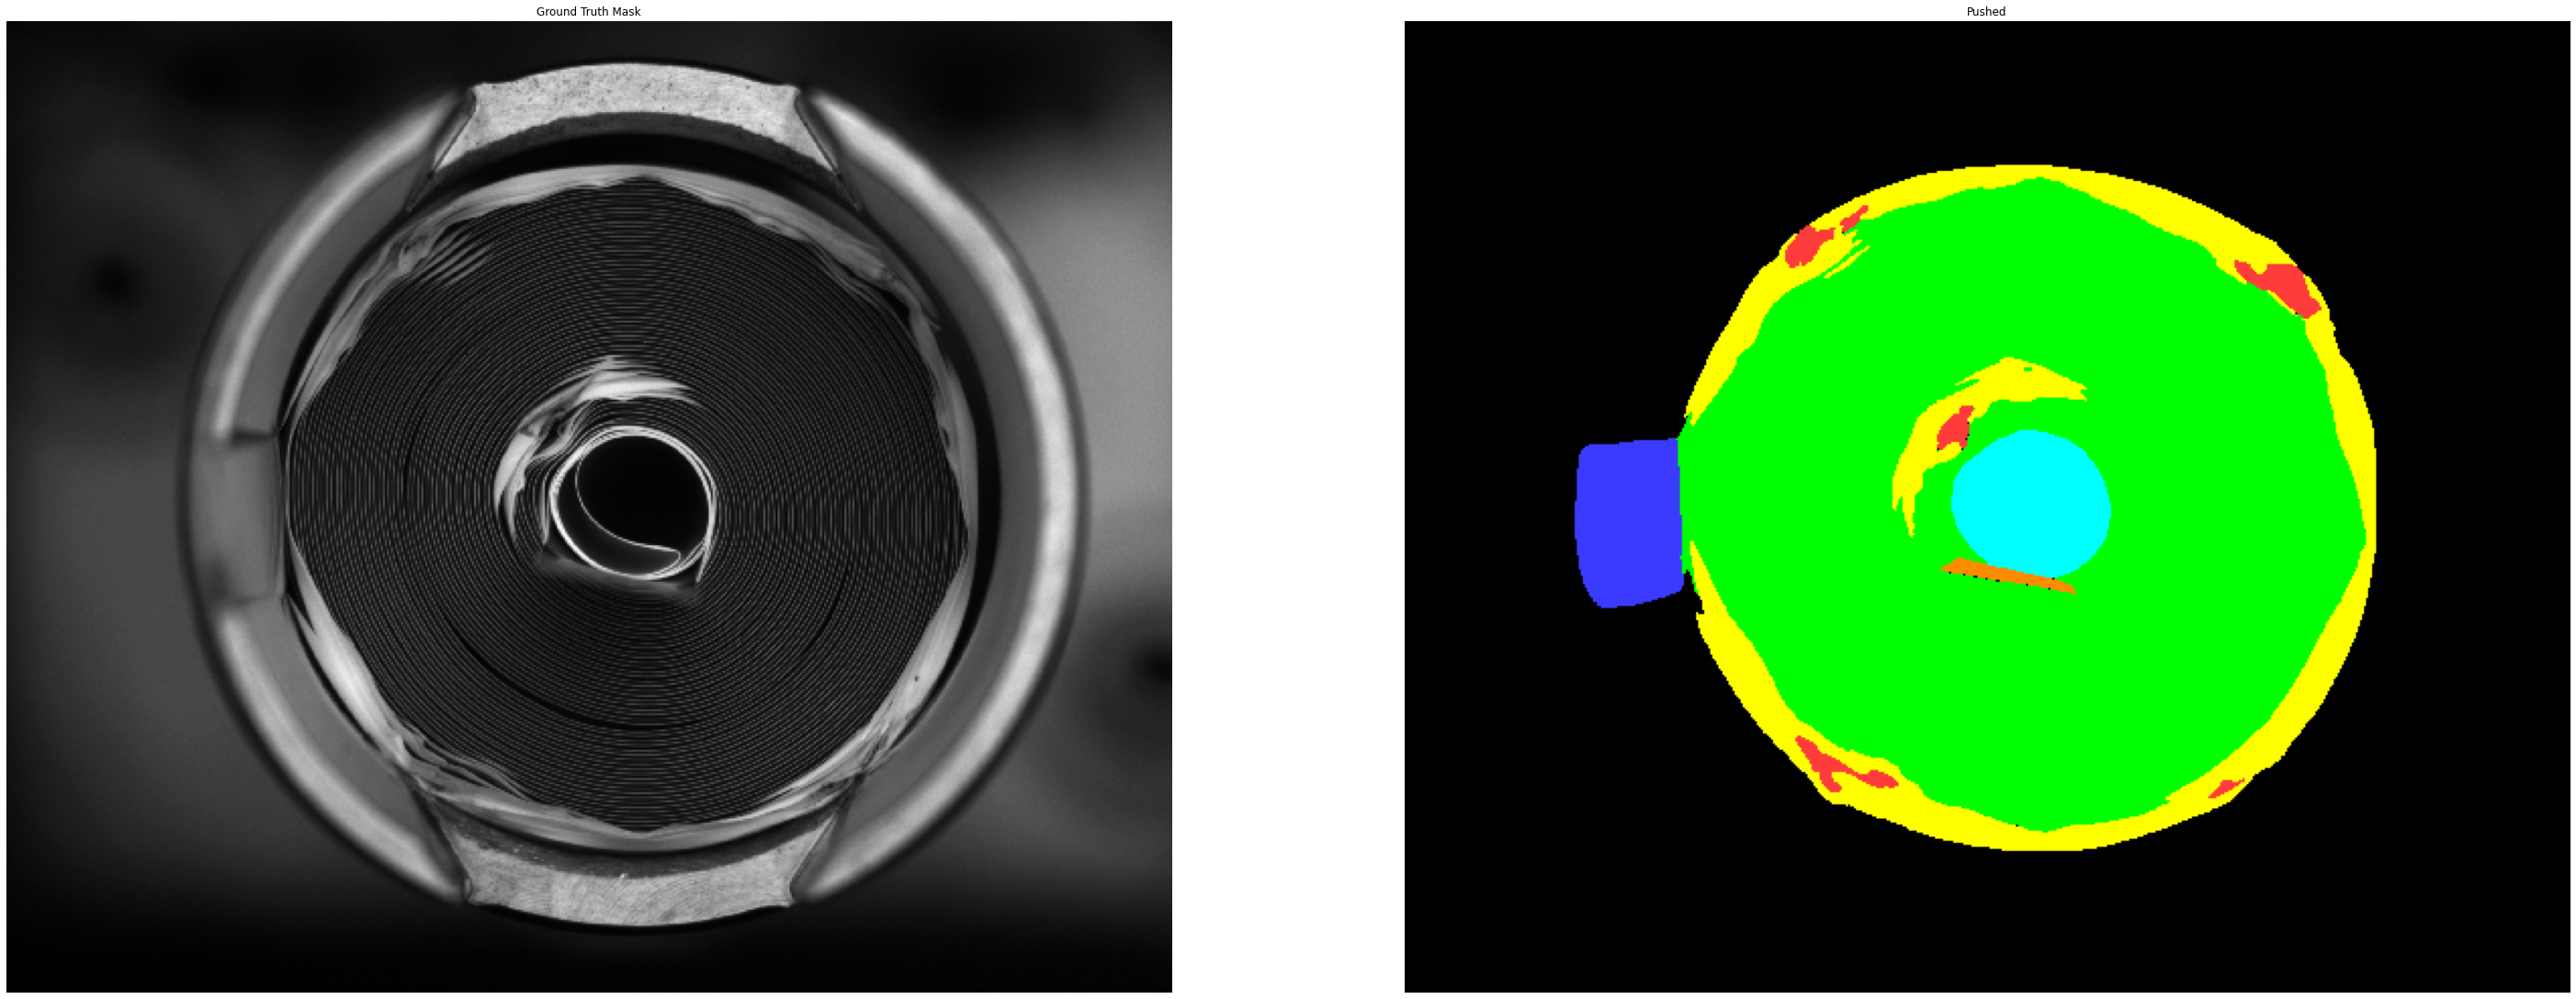

In [37]:
pred = np.float32(pred_mask[idx][0][0])

ex = np.round(pred) # ex = H,W,7

circle = tf.expand_dims(ex[:,:,1], -1)
pushed = tf.expand_dims(ex[:,:,3], -1) 
bg = tf.expand_dims(ex[:,:,0], -1)
hole = tf.expand_dims(ex[:,:,2], -1)
stamped = tf.expand_dims(ex[:,:,4], -1)
in_tab = tf.expand_dims(ex[:,:,5], -1)
out_tab = tf.expand_dims(ex[:,:,6], -1)
    
channel_0 = np.zeros(IMG_SIZE+(1,)) #prediction
channel_1 = np.zeros(IMG_SIZE+(1,))
channel_2 = np.zeros(IMG_SIZE+(1,))

channel_0[pushed==1] = color_dict[3][0]
channel_1[pushed==1] = color_dict[3][1]
channel_2[pushed==1] = color_dict[3][2]

channel_0[circle==1] = color_dict[1][0]
channel_1[circle==1] = color_dict[1][1]
channel_2[circle==1] = color_dict[1][2]

channel_0[stamped==1] = color_dict[4][0]
channel_1[stamped==1] = color_dict[4][1]
channel_2[stamped==1] = color_dict[4][2]

channel_0[bg==1] = color_dict[0][0]
channel_1[bg==1] = color_dict[0][1]
channel_2[bg==1] = color_dict[0][2]

channel_0[hole==1] = color_dict[2][0]
channel_1[hole==1] = color_dict[2][1]
channel_2[hole==1] = color_dict[2][2]

channel_0[in_tab==1] = color_dict[5][0]
channel_1[in_tab==1] = color_dict[5][1]
channel_2[in_tab==1] = color_dict[5][2]

channel_0[out_tab==1] = color_dict[6][0]
channel_1[out_tab==1] = color_dict[6][1]
channel_2[out_tab==1] = color_dict[6][2]

com = tf.concat([channel_0, channel_1, channel_2], -1)

display([val_x[idx], com],fig_size=50) #, idx=idx, only_inference=True) #WHEN SAVING
#display([val_x[idx], onehot_to_rgb(val_y[idx]), com],fig_size=50)

In testing Mode...


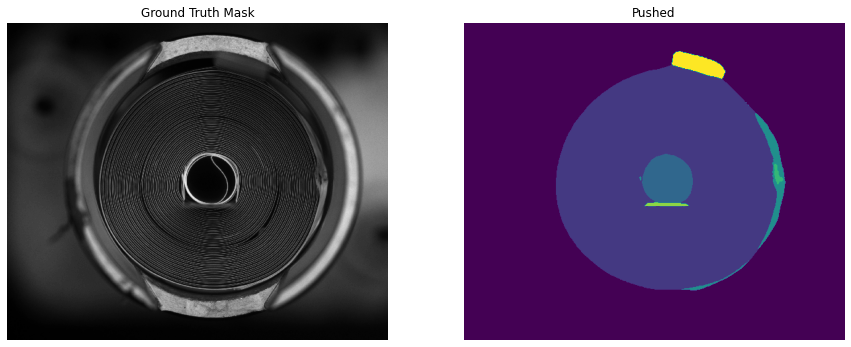

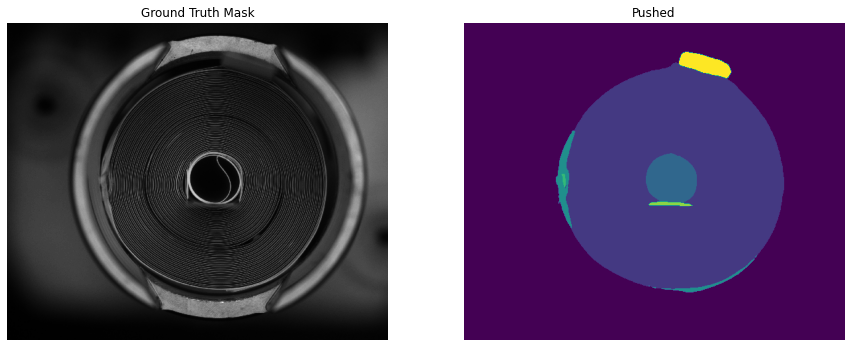

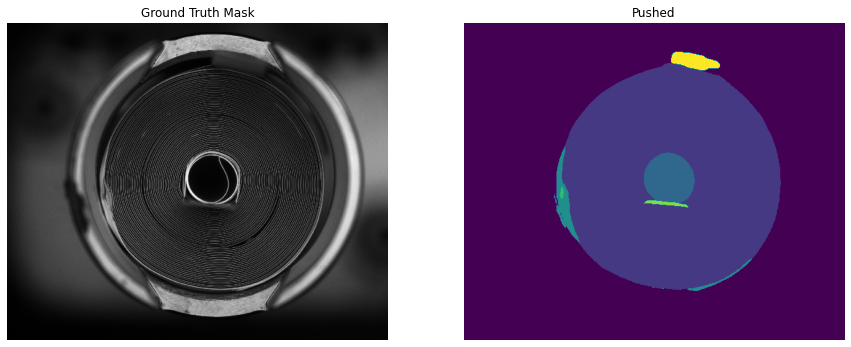

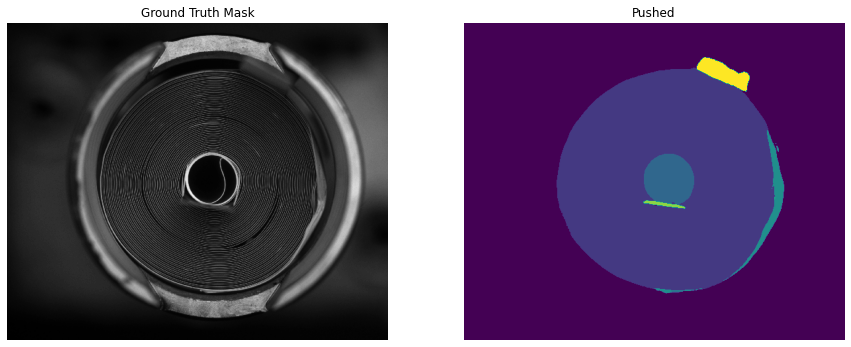

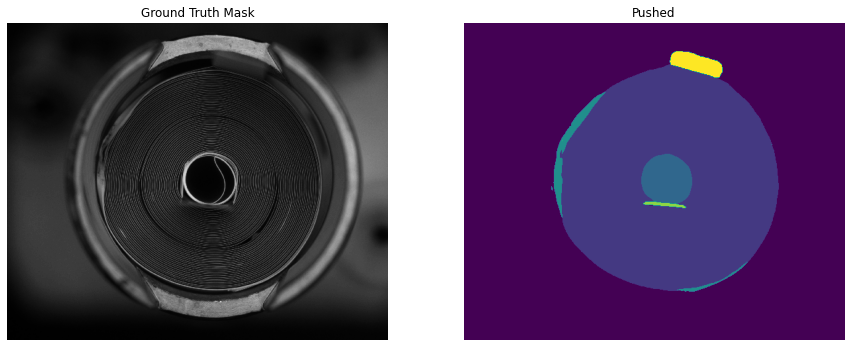

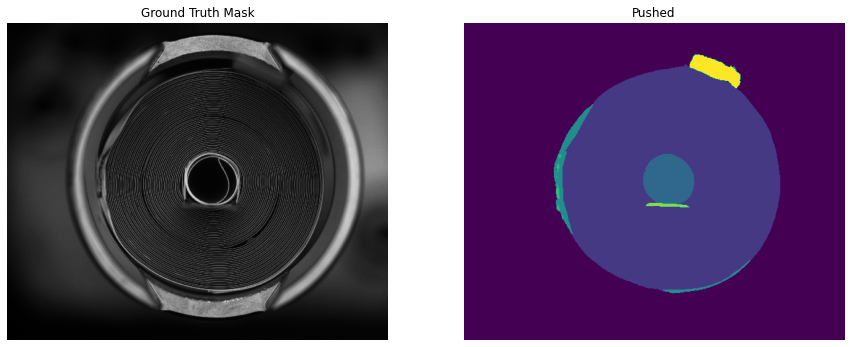

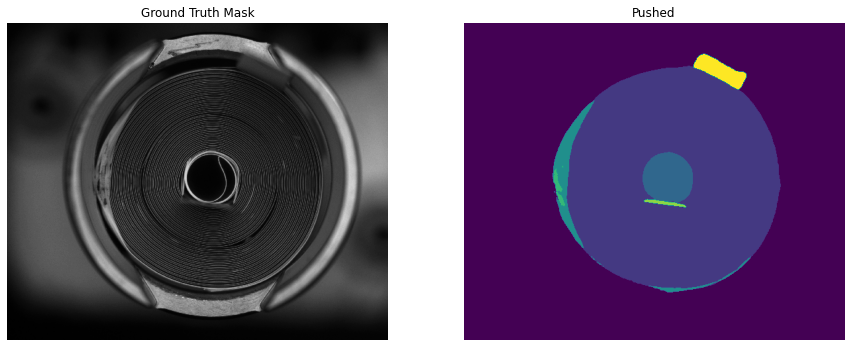

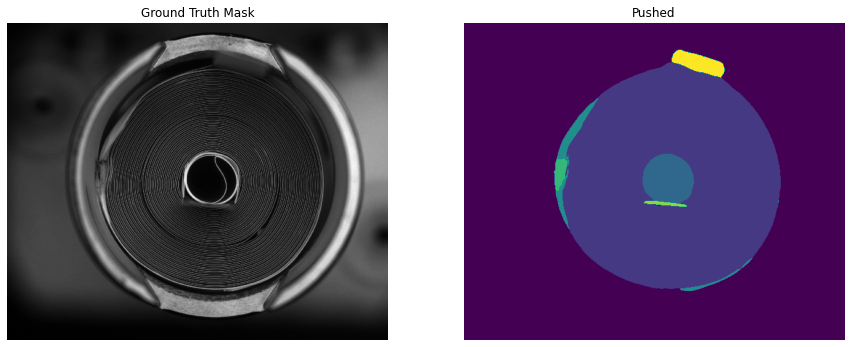

In [41]:
show_predictions(test_mode=True, x = val_x, num=8)

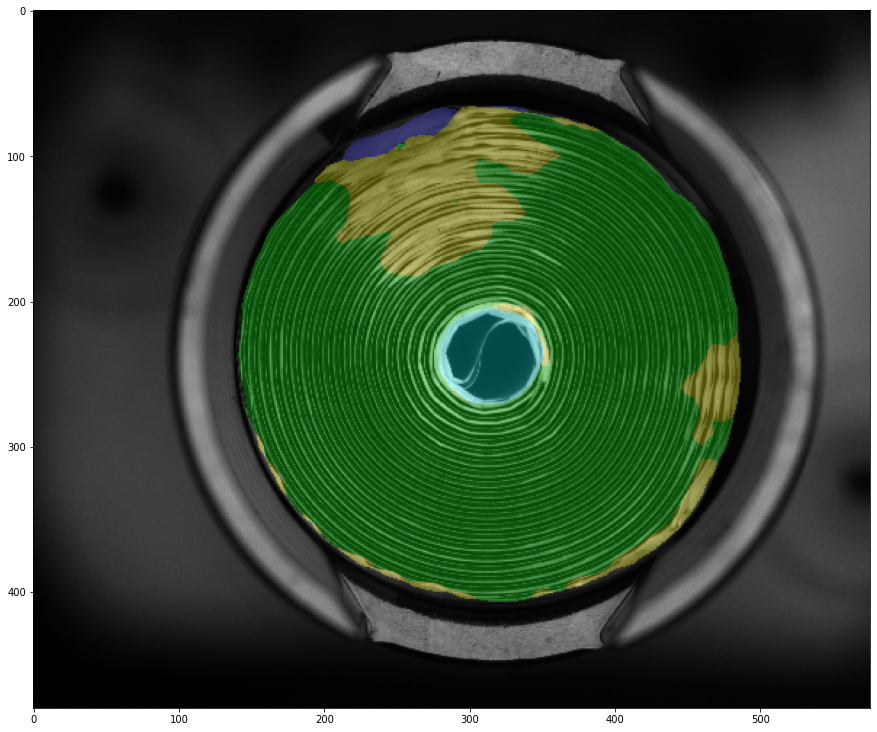

In [68]:
NUM_IMGS = val_x.shape[0]

img1 = np.array(val_x[idx], np.float64)
img1 = tf.image.grayscale_to_rgb(tf.convert_to_tensor(img1))

pred = np.float32(pred_mask[idx][0][0])
ex = np.round(pred) # ex = H,W,5
# 0 bg, 1 Circle 2 hole 3 stamp 4 psuhed 

circle = tf.expand_dims(ex[:,:,1], -1)
pushed = tf.expand_dims(ex[:,:,3], -1) 
bg = tf.expand_dims(ex[:,:,0], -1)
hole = tf.expand_dims(ex[:,:,2], -1)
stamped = tf.expand_dims(ex[:,:,4], -1)
in_tab = tf.expand_dims(ex[:,:,5], -1)
out_tab = tf.expand_dims(ex[:,:,6], -1)

channel_0 = np.zeros(IMG_SIZE+(1,)) #prediction
channel_1 = np.zeros(IMG_SIZE+(1,))
channel_2 = np.zeros(IMG_SIZE+(1,))

# 0 bg, 1 Circle 2 hole 3 stamp 4 psuhed 

channel_0[pushed==1] = color_dict[3][0]
channel_1[pushed==1] = color_dict[3][1]
channel_2[pushed==1] = color_dict[3][2]

channel_0[circle==1] = color_dict[1][0]
channel_1[circle==1] = color_dict[1][1]
channel_2[circle==1] = color_dict[1][2]

channel_0[stamped==1] = color_dict[4][0]
channel_1[stamped==1] = color_dict[4][1]
channel_2[stamped==1] = color_dict[4][2]

channel_0[bg==1] = color_dict[0][0]
channel_1[bg==1] = color_dict[0][1]
channel_2[bg==1] = color_dict[0][2]

channel_0[hole==1] = color_dict[2][0]
channel_1[hole==1] = color_dict[2][1]
channel_2[hole==1] = color_dict[2][2]

channel_0[in_tab==1] = color_dict[5][0]
channel_1[in_tab==1] = color_dict[5][1]
channel_2[in_tab==1] = color_dict[5][2]

channel_0[out_tab==1] = color_dict[6][0]
channel_1[out_tab==1] = color_dict[6][1]
channel_2[out_tab==1] = color_dict[6][2]

com = tf.concat([channel_0, channel_1, channel_2], -1)

img2 = np.array(com, np.float64)
alpha = 0.75

blended = cv2.addWeighted(np.array(img1), alpha, img2, (1-alpha), 0) # 방식2
#blended1 = blended.astype(np.uint8)

display([blended], idx=idx, loc='test_images/validation/alpha_blended', name='blended', only_inference=True, fig_size=15)

In [17]:
def get_iou(val_y, cls): #0:bg 1:circle 2:hole 3: pressed 4 dent
    iou = []
    fp = []
    fn = []
    tn = []
    tp = []
    
    for idx in range(46,56):
        ex = np.round(pred_mask[idx][0][0]) # ex = H,W,4

        y_pred = tf.expand_dims(ex[:,:,cls], -1)

        gt_mask = np.round(val_y[idx],decimals = 0)
        if cls not in np.unique(gt_mask): continue
            
        y_true = np.zeros(IMG_SIZE + (1,))
        y_true[gt_mask == cls] = 1
        

        FP = len(np.where(y_pred - y_true  == -1)[0]) #0,1
        FN = len(np.where(y_pred - y_true  == 1)[0]) #1,0
        TP = len(np.where(y_pred + y_true ==2)[0]) #1,1
        TN = len(np.where(y_pred + y_true == 0)[0]) #0,0
        
        cmat = [[TP, FN], [FP, TN]]
        
        if TP+FN+FP == 0 or FN+TP ==0 or FP+TN==0: 
            continue
        
        fp.append(FP)
        fn.append(FN)
        tn.append(TN)
        tp.append(TP)
    
        iou.append (TP/(TP+FN+FP))
        
    
    return ( np.mean(iou), np.mean(fn), np.mean(fp), np.mean(tn), np.mean(tp) )
        
stamp_iou, stamp_fn, stamp_fp, stamp_tn, stamp_tp = get_iou(val_y, cls=4)
pushed_iou, pushed_fn, pushed_fp, pushed_tn, pushed_tp = get_iou(val_y, cls=3)
circle_iou, circle_fn, circle_fp, circle_tn, circle_tp = get_iou(val_y, cls=1)
hole_iou, hole_fn, hole_fp, hole_tn, hole_tp = get_iou(val_y, cls=2)
in_iou, in_fn, in_fp, in_tn, in_tp = get_iou(val_y, cls=5)
out_iou, out_fn, out_fp, out_tn, out_tp = get_iou(val_y, cls=6)

In [18]:
print("STAMP IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(stamp_iou, stamp_fn, stamp_fp, stamp_tn, stamp_tp, 
                                                                               stamp_fn/(stamp_fn+stamp_tp), 
                                                                               stamp_fp/(stamp_fp+stamp_tn)))
print("PUSHED IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(pushed_iou, pushed_fn, pushed_fp,pushed_tn,pushed_tp, 
                                                                                pushed_fn/(pushed_fn+pushed_tp), 
                                                                               pushed_fp/(pushed_fp+pushed_tn)))
print("CIRCLE IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(circle_iou, circle_fn, circle_fp, circle_tn,
                                                                               circle_tp, circle_fn/(circle_fn+circle_tp), 
                                                                               circle_fp/(circle_fp+circle_tn)))
print("HOLE IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(hole_iou, hole_fn, hole_fp, hole_tn,
                                                                               hole_tp, hole_fn/(hole_fn+hole_tp), 
                                                                               hole_fp/(hole_fp+hole_tn)))
print("IN_TAB IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(in_iou, in_fn, in_fp, in_tn,
                                                                               in_tp, in_fn/(in_fn+in_tp), 
                                                                               in_fp/(in_fp+in_tn)))
print("OUT_TAB IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(out_iou, out_fn, out_fp, out_tn,
                                                                               out_tp, out_fn/(out_fn+out_tp), 
                                                                               out_fp/(out_fp+out_tn)))

STAMP IoU: 0.35031798233837513, FN: 415.3333333333333, FP: 571.8333333333334, TN: 275011.5, TP: 481.3333333333333, FNR: 0.46319702602230484, FPR: 0.002074992440278198
PUSHED IoU: 0.7939923728198258, FN: 1311.5714285714287, FP: 985.1428571428571, TN: 265424.0, TP: 8759.285714285714, FNR: 0.130234339536995, FPR: 0.0036978567874118434
CIRCLE IoU: 0.9824628414566563, FN: 806.2, FP: 586.4, TN: 195427.9, TP: 79659.5, FNR: 0.010019175872452487, FPR: 0.0029916184686525423
HOLE IoU: 0.9545868986089368, FN: 77.5, FP: 130.4, TN: 271909.7, TP: 4362.4, FNR: 0.01745534809342553, FPR: 0.0004793410971397231
IN_TAB IoU: 0.7832798082415043, FN: 52.8, FP: 49.3, TN: 276025.7, TP: 352.2, FNR: 0.13037037037037036, FPR: 0.00017857466268224214
OUT_TAB IoU: 0.8933130964323986, FN: 53.1, FP: 383.9, TN: 272368.7, TP: 3674.3, FNR: 0.014245855019584697, FPR: 0.0014075026232563867
